In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Functions

In [2]:
def make_vote_df_from_proposal_id(proposal_id):
    url = 'https://hub.snapshot.org/graphql/'
    vote_query = create_vote_query(proposal_id)
    vote_response = requests.post(url, json={'query': vote_query})
    print(proposal_response.status_code,proposal_response.reason,proposal_id)
    vote_json = vote_response.json()
    vote_df = vote_json_to_df(vote_json)
    return vote_df
    
def create_vote_query(proposal_id):
    vote_query = '''
    query Votes {
      votes (
        first: 9999999
        skip: 0
        where: {
          proposal: "'''+ proposal_id + '''"
        }
        orderBy: "created",
        orderDirection: desc
      ) {
        id
        ipfs
        voter
        created
        space {
          id
        }
        proposal {
          id
        }
        choice
        metadata
        vp
        vp_by_strategy
        vp_state
      }
    }
    '''
    return vote_query
def vote_json_to_df(vote_json):
    row_as_series_list=[]
    for vote in vote_json['data']['votes']:
        id = vote['id']
        ipfs = vote['ipfs']
        voter = vote['voter']
        created = vote['created']
        space = vote['space']['id']
        proposal = vote['proposal']['id']
        choice = vote['choice']
        #metadata = vote['metadata']: {},
        vp = vote['vp']
        vp_by_strategy = tuple(vote['vp_by_strategy'])
        vp_state = vote['vp_state']
        row_as_series  = pd.Series(
            data=(
                id,
                ipfs,
                voter,
                created,
                space,
                proposal,
                choice,
                #metadata,
                vp,
                vp_by_strategy,
                vp_state,
                ),
            index=(
                'vote_id',
                'ipfs',
                'voter',
                'created',
                'space',
                'proposal',
                'choice',
                #'metadata',
                'vp',
                'vp_by_strategy',
                'vp_state',
            )
        )
        row_as_series_list.append(row_as_series)
    return_df = pd.DataFrame(row_as_series_list)
    return return_df


# Querying and Dumping the Data

In [3]:
proposal_query = '''
query Proposals {
  proposals (
    first: 10000000
    where: {
      space_in: ["index-coop.eth"],
      state: "closed"
    },
    orderBy: "created",
    orderDirection: desc
  ) {
    id
    title
    body
    choices
    start
    end
    snapshot
    state
    author
    scores
    scores_by_strategy
    scores_state
    scores_total
    scores_updated
    created
    votes
    space {
      id
      name
    }
  }
}
'''
#print(proposal_query)

In [4]:
url = 'https://hub.snapshot.org/graphql/'
proposal_response = requests.post(url, json={'query': proposal_query})
print(proposal_response.status_code,proposal_response.reason)

200 OK


In [5]:
proposal_json = proposal_response.json()

In [6]:
#proposal_json

In [7]:
#proposal_json

In [8]:
# Dump Proposal Dataframe
proposal_row_list = []
for proposal in proposal_json['data']['proposals']:
    id = proposal['id']
    title = proposal['title']
    body = proposal['body']
    choices = tuple(proposal['choices'])
    scores = tuple(proposal['scores'])
    scores_total = proposal['scores_total']
    votes = proposal['votes']
    created = proposal['created']
    
    proposal_row = pd.Series(data=[id,created, title,body,choices,scores,scores_total,votes],
                      index = ['proposal_id','created','title','body','choices','scores','scores_total','votes']
                     )
    proposal_row_list.append(proposal_row)

proposals_df = pd.DataFrame(proposal_row_list)



## Cleaning Proposal df

In [9]:
def make_proposal_category(title):
    '''
    Logic for parsing the title to categorize the proposal.
    '''
    if ('DG1' in title or 'Decision Gate 1' in title):
        category = 'DG1'
    elif ('DG2' in title or 'Decision Gate 2' in title): 
        category = 'DG2'
    elif ('IIP' in title): 
        category = 'IIP'
    else: 
        category = 'Metagovernance'
    return category
def make_proposal_result(row):
    '''
    Logic for checking if the proposal passed or not. 
    1 is FOR
    2 is AGAINST
    '''
    category = row['category']
    percentage_for = row['percentage_for']
    #print(category)
    #print(percentage_for)
    #print(type(percentage_for))
    if category == 'DG2':
        if percentage_for >.6:
            return 1 
        else:
            return 2
    else:
        if percentage_for >.5:
            return 1
        else:
            return 2
    

In [10]:
proposals_df['created'] = pd.to_datetime(proposals_df['created'],unit='s')
proposals_df['category'] = proposals_df['title'].apply(make_proposal_category) # Make category column
proposals_df = proposals_df[proposals_df['choices'].apply(len) == 2] # Remove multi-choice proposals
proposals_df = proposals_df[proposals_df['scores_total'] !=0] # Remove dummy proposals
proposals_df['reached_quorum'] = proposals_df['scores_total'] > 100000 # 100k is a placeholder value for quorum 
proposals_df['percentage_for'] = proposals_df['scores'].map(lambda x: x[0])/proposals_df['scores_total']
proposals_df['result'] = proposals_df.apply(make_proposal_result,axis=1) # Make category column
proposals_df.to_json('proposals_df.json')

In [11]:
proposals_df

,proposal_id,created,title,body,choices,scores,scores_total,votes,category,reached_quorum,percentage_for,result
0,0x6bffe77e0c6da784b8e82b07ff1b2988bcfc50b60281...,2021-12-08 19:18:14,[BALANCER-undefined] MTA <> BAL Treasury Swap,This proposal is for voting on Balancer's prop...,"(Yes, let's do it, No, this is not the way)","(3622.3267330135936, 0)",3622.326733,8,Metagovernance,False,1.000000,1
1,QmXBS8j6F64gkaV78jyvtDMDzvUHvugJNqCrncWeecE5au,2021-12-06 17:39:48,[AAVE-undefined] Add G-UNI to Aave V2 AMM Market,This proposal is for voting on Aave's proposal...,"(For, Against)","(28890.0203218128, 0)",28890.020322,29,Metagovernance,False,1.000000,1
2,QmceW9t1BpsuvJYue8VsR7hodte6L95rUV2pGSZALJX2vb,2021-11-30 23:18:26,"[COMPOUND-72] Risk Parameter Updates for WBTC,...",This proposal is for voting on Compound's prop...,"(For, Against)","(24980.931571880352, 0)",24980.931572,49,Metagovernance,False,1.000000,1
3,Qmf9zQAiL1eJwDhy7SPXhNjSNhga3xnHrxLp373amCGnzV,2021-11-30 17:31:32,[AAVE-50] Q2 Dynamic Risk Parameters,This proposal is for voting on Aave's proposal...,"(For, Against)","(287762.3443888976, 0)",287762.344389,36,Metagovernance,True,1.000000,1
4,0xc6b656f97240505912508f6a47ca0bf117732833da22...,2021-11-29 16:30:42,IIP-113: Index Coop Product Launch & Maintenan...,"Status: Proposed\nAuthor(s): @cavalier_eth, @d...","(FOR, AGAINST)","(109994.5318624229, 470487.62399540434)",580482.155858,95,IIP,True,0.189488,2
...,...,...,...,...,...,...,...,...,...,...,...,...
203,QmSSZzLPbLpegBWfxPBTVAdvUZoXAL2V6Hi58YHEi6bemW,2020-12-16 02:13:40,IIP-7 CoinShares Gold and Cryptoassets Index L...,## Simple Summary\n\nThe CoinShares Gold and C...,"(FOR, AGAINST)","(207237.6314297594, 136489.5390568919)",343727.170487,93,IIP,True,0.602913,1
204,QmethJXKnCMd89wWBaxCBRcK2Hu8Dhx5E5AM7XeHEKsL1n,2020-12-11 21:20:11,[COMPOUND-32] Distribute COMP to Affected User...,This proposal is for voting on Compound's prop...,"(For, Against)","(67189.52469698468, 108859.87904773426)",176049.403745,77,Metagovernance,True,0.381652,2
205,QmTdYHoyT5eLWSZduHkivVxs3Vree1EUQUYCk8uoW4Q1EA,2020-12-07 21:50:10,[COMPOUND-31] Adjusting Reserve Factors,This proposal is for voting on Compound's prop...,"(For, Against)","(108963.72591013898, 0.01090957898367475)",108963.736820,45,Metagovernance,True,1.000000,1
206,QmRw6FoXJRhm4WLaWVuRgsXhE7ZfWvAKY42E386ksugfUC,2020-12-06 06:10:07,[COMPOUND-30] COMP Contributor Grants,This proposal is for voting on Compound's prop...,"(For, Against)","(138478.01939721234, 85.89796163862161)",138563.917359,82,Metagovernance,True,0.999380,1


### Double check that the choices are in the correct order

In [12]:
proposals_df['choices'].value_counts()

(FOR, AGAINST)                                                         102
(For, Against)                                                          87
(Approve, Reject)                                                        4
(FOR , AGAINST)                                                          2
(Yes, let's do it, No, this is not the way)                              1
(Yes, No)                                                                1
(Fund Balancer Grants DAO Wave 2, Do not fund)                           1
(Stop BAL for Gas, Continue BAL for Gas)                                 1
(Approve, Deny)                                                          1
(Proceed with "Whale" Sponsorship, Do not proceed with sponsorship)      1
(Approve Grant, Deny Grant)                                              1
(Yes, I support this proposal, No, I am against this proposal)           1
(yes, I vote for this proposal, no, I vote against this proposal)        1
(Yes we would love a Tele

When we did this, we wanted the first choice to always be "yes"

In [13]:
#

In [14]:
# Dump Vote Dataframe
votes_df_list = []
for proposal in proposal_json['data']['proposals']:
    #print(proposal['state'],proposal['choices'])
    if proposal['state'] != 'closed':
        continue
    else:
        votes_for_proposals_df = make_vote_df_from_proposal_id(proposal['id'])
        votes_df_list.append(votes_for_proposals_df)
        
all_votes_df = pd.concat(votes_df_list,ignore_index=True)
all_votes_df['created'] = pd.to_datetime(all_votes_df['created'],unit='s') #Convert to datetime


200 OK 0x6bffe77e0c6da784b8e82b07ff1b2988bcfc50b60281ba6035a9fc88854fb3d7
200 OK QmXBS8j6F64gkaV78jyvtDMDzvUHvugJNqCrncWeecE5au
200 OK QmceW9t1BpsuvJYue8VsR7hodte6L95rUV2pGSZALJX2vb
200 OK Qmf9zQAiL1eJwDhy7SPXhNjSNhga3xnHrxLp373amCGnzV
200 OK 0xc6b656f97240505912508f6a47ca0bf117732833da22817252d3c1c7100fcd69
200 OK 0x44ba0f55de0c4d6875b36f3f7cdacb3b144bd782d9535c52862cd8c41fd1848f
200 OK 0x1aa4fdb6f42d866c7ba5f80ceea61358051039df7a22385a29c8401c1146f7cf
200 OK 0xba1e51dcaa304833ec3307b0c95fdf525443cfe477d682c735206bdf6ebe5a62
200 OK 0xd031343b706075a757650903fc1d3f5e9676f6eff682cc6b1c5692a1607b763f
200 OK 0x4dee2def2333c40a5fdbe244cc0e641f099acb44edccc9ba8101dfbf37555353
200 OK 0xbecffc979a7e3c1d98844a239987ceeeaa8f0c43d49fc8995e7905371636675b
200 OK 0x0b70d0cdd97874eca00769fe1c323351a3e7c473bff876b2662e8d3e0a1e75bb
200 OK 0xab2226aff5ab574d15e357c0815e65a89b817dc741bb5bfa1a4d48802010c984
200 OK 0x81ba2833504ea67c0d82e923a500afb54aa62ca74eeded97be6050d947a47e8e
200 OK QmaGZeBayJGQpFZWY

200 OK QmeBLQBrtAukRwsv8235xc8HA21i3bL7xEThHhcAWNAhSh
200 OK QmdgNav7hJBCwk1MQyEvV1Y2Lm83pDHegK2bEAV73cmL7i
200 OK QmYUmTZwZfjKXPcNucBCRzwWTNLucYBP6UpPxztr9sN5Ci
200 OK QmWTBBjj4cty1rmVuyujjV1hvNVVCBQaHbx3FSxKkEfD4R
200 OK QmXxzDhCtAgN9aPXyMRosD8UaNMajyHv3LqzbyhJeDBcxG
200 OK QmZ1VHJWfo1rZjPdki3NgLu9m32QqfbkVU5TXhS5TFVmpG
200 OK QmZwfWV6h1wjFKvjhnKJXJSDY3tYdxyE6RyqpMCDABZPqQ
200 OK QmUvb2cLaVw96Ua69rtvJoVvZ6QJr6ypyUYCX9Hkb4YBNf
200 OK QmeqmnsThQNCjdhVno9Fhjtk3zkkUUKT6SkrQNBpRpENbi
200 OK QmU3wEFKty118Tws75zmf2VHtBGPDcqCvLWn8ehN4PsYhL
200 OK QmfYyqbcsrHtkcsZ3LGcVyorCN72p511jzv6m2wbYvCjZv
200 OK QmPm9X4XYTuoALKAjUyQTB5Ra3jpeJuzpmaurniP3Ly1MS
200 OK QmSreGqJJ4z1XzG1mympZqTVG8DCNRs5S1Pzk2T5VeUofY
200 OK QmbvjYrAKDHKcRQHagxX5UZHgAJeCz9j3FUpTEzW2eEizV
200 OK QmNXd7DkRELDHBajFPYhLgqzA92zWJECNt7m5hhPRwXe6U
200 OK QmWCsf6bwsg2Xt5GbGM5DTjUDD4JWce1irVxEhmza8bj8C
200 OK QmbyA286dMzYRQDuYdMghCAUKXQH3hZWp4FQ5m8kYoL5Ki
200 OK QmPDTLqmThdHqpG8TSXBmkHEYYZetc4dbNh3CCHRUfphnn
200 OK QmSYRYTvuy1XuSP5dgwFo

## Cleaning Vote Dataframe

In [15]:
def remove_zero_vp_proposals(all_votes_df):
    vp_sum_df = all_votes_df.groupby('proposal')['vp'].sum() 
    zero_vp_proposals = vp_sum_df[vp_sum_df==0].index
    all_votes_df = all_votes_df[~all_votes_df['proposal'].isin(zero_vp_proposals)]
    return all_votes_df

In [16]:
all_votes_df = remove_zero_vp_proposals(all_votes_df) 
all_votes_df.to_json('all_votes_df.json')

# Analysis

###  What percentage of proposals are unanimous?


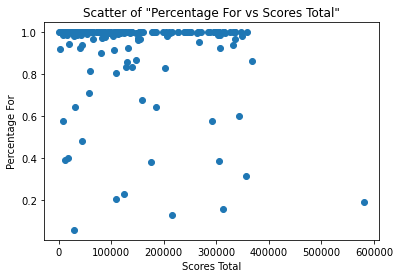

In [17]:
# What percentage of proposals are unanimous?
proposals_df['percentage_for'] = proposals_df['scores'].map(lambda x: x[0])/proposals_df['scores_total']
plt.scatter(proposals_df['scores_total'],proposals_df['percentage_for'])
plt.xlabel('Scores Total')
plt.ylabel('Percentage For')
plt.title('Scatter of "Percentage For vs Scores Total"')
plt.show()

# Deciding Vote Analysis

In [26]:
def winning_threshold(choice,category):
    if category == 'DG2':
        if choice == 1:
            return .6
        else:
            return .4
    else:
        return .5
    
def is_deciding_vote(row):
    '''
    Assuming that a vote is ALREADY on the winning side,
    A vote is a considered a deciding vote if the following statement holds:
    'If the vote had switched sides, then it would have still been on the winning side.'
    '''
    vp = row['vp']
    choice = row['choice']
    category = row['category']
    scores_total = row['scores_total']
    coalition_vp = row['coalition_vp']
    reached_quorum = row['reached_quorum']
    
    if not reached_quorum:
        return "no quorum"
    else:
        #old_choice = choice
        #old_my_team_score= coalition_vp
        #old_enemy_team_score = scores_total-coalition_vp

        new_choice = (choice) % 2 + 1 # 1 goes to 2, 2 goes to 1
        new_coalition_vp = scores_total-(coalition_vp-vp)


        new_percentage = new_coalition_vp/scores_total

        new_wins = new_percentage > winning_threshold(new_choice,category)
        
        if new_wins:
            return 'Was Deciding Voter'
        else:
            return 'Not Deciding Voter'

In [27]:
#Merge
merged_df = pd.merge(all_votes_df,proposals_df,left_on='proposal',right_on='proposal_id',how='inner')

In [28]:
#Create columns
merged_df['coalition_vp'] = merged_df.apply(lambda row: row.scores[row.choice-1],axis=1)
merged_df['coalition_contribution'] = merged_df['vp']/merged_df['coalition_vp']
merged_df['is_winning_coalition'] = merged_df['choice']==merged_df['result']

In [29]:
# Winning Coalition DF has all of the data denormalized and in one giant DF, with all of the processing
# steps attached to it.
winning_coalition_df = merged_df[merged_df['is_winning_coalition']]
winning_coalition_df['is_deciding_vote'] = winning_coalition_df.apply(is_deciding_vote,axis=1)


/var/folders/gk/ws1y65fn3l3_f44tyj7ms26h0000gn/T/ipykernel_66483/1840099.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winning_coalition_df['is_deciding_vote'] = winning_coalition_df.apply(is_deciding_vote,axis=1)


In [37]:
# Dump all votes to csv
winning_coalition_df.to_csv('all_votes_processed.csv')

In [31]:
#Pivot
deciding_vote_df = winning_coalition_df.sort_values(by='coalition_contribution',ascending=False).groupby(['voter','is_deciding_vote']).size()\
                       .reset_index(name='counts')\
                       .pivot_table(index='voter',columns='is_deciding_vote',values='counts',fill_value=0)\
                       .sort_values(by='Was Deciding Voter',ascending=False)

In [32]:
voter_by_vp_df = winning_coalition_df.groupby('voter').agg(mean_vp=('vp', 'mean'),
                                                           min_vp=('vp', 'min'),
                                                           max_vp=('vp', 'max'),
                                                          )
#voter_by_vp_df

In [33]:
merged_deciding_vote_df = deciding_vote_df.merge(voter_by_vp_df,on='voter',how='inner')

In [34]:
# Dump by_Voter DF to CSV for upload to google sheets
merged_deciding_vote_df.to_csv('merged_deciding_vote_by_voter.csv')

### Deciding voters and how much VP they have

In [38]:
merged_deciding_vote_df.round(0).head(20)

,Not Deciding Voter,Was Deciding Voter,no quorum,mean_vp,min_vp,max_vp
voter,,,,,,
0x8627be8D8b6D250c87f802D0c48C26FA807A0857,0,33,0,187922.0,187922.0,187922.0
0x4a3e950c35c6d9c2d8f5F0a6CC03aF9942134840,12,8,0,71242.0,44093.0,80640.0
0x365047213ABe97401e8Bfa2c48D12d2731601F98,0,6,0,196330.0,123949.0,235515.0
0x4EC7CdF61405758f5cED5E454c0B4b0F4F043DF0,10,3,0,68307.0,66832.0,68569.0
0xcfc50541c3dEaf725ce738EF87Ace2Ad778Ba0C5,7,2,0,50476.0,48639.0,52790.0
0xb647055A9915bF9c8021a684E175A353525b9890,2,1,0,100000.0,100000.0,100000.0
0x9fB64b232dEa3ba6e020F517b2BC8aFd0145880c,0,1,0,41225.0,41225.0,41225.0
0xB933AEe47C438f22DE0747D57fc239FE37878Dd1,8,1,0,31187.0,29522.0,31395.0
0xaAa604E8f5318373D1785766D4f7310AF6CC4891,29,1,10,24018.0,22950.0,24768.0


In [45]:
def sum_true(grp):
    return np.sum(grp=='Was Deciding Voter')
def create_has_deciding_vote(row):
    if row['reached_quorum'] == False:
        return 'no quorum'
    else:
        if row['num_deciding_votes']>0:
            return 'Has Deciding Voter'
        else:
            return 'No Deciding Voter'

In [46]:
deciding_votes_by_proposal_df = winning_coalition_df.groupby(['proposal','category','votes','reached_quorum'])\
    .agg(num_deciding_votes=('is_deciding_vote',sum_true)).reset_index()
                       
deciding_votes_by_proposal_df['has_deciding_vote'] = deciding_votes_by_proposal_df.apply(create_has_deciding_vote,axis=1) 

 Note, there are two proposals with more than 1 deciding vote

### Number of deciding votes by Proposal

In [47]:
deciding_votes_by_proposal_df

,proposal,category,votes,reached_quorum,num_deciding_votes,has_deciding_vote
0,0x0b70d0cdd97874eca00769fe1c323351a3e7c473bff8...,DG2,61,True,1,Has Deciding Voter
1,0x1aa4fdb6f42d866c7ba5f80ceea61358051039df7a22...,IIP,64,True,0,No Deciding Voter
2,0x26ea01b07411488227517a164bdfa5ee5c06792bd976...,IIP,54,True,1,Has Deciding Voter
3,0x31a11f7f37c0319785cad3ab7353745731c3d33908b5...,DG1,66,True,1,Has Deciding Voter
4,0x40edf5d2828a0473626a8a7bfa22a8755fb847a95563...,DG1,57,True,1,Has Deciding Voter
...,...,...,...,...,...,...
201,Qmf9zQAiL1eJwDhy7SPXhNjSNhga3xnHrxLp373amCGnzV,Metagovernance,36,True,1,Has Deciding Voter
202,QmfEFdo3byE9XsgfZrP2XG7VJwoeYSb3m56oF93hDeDMth,IIP,59,True,0,No Deciding Voter
203,QmfGRkXA5gj2ske8Ci45wZnA9BRQg38iQ9vkpegABi9EbW,IIP,85,True,0,No Deciding Voter
204,QmfMqLAiJmgjTpNaXyVFkZtCaV2kBDtzp4dMhzdvzQCrKZ,Metagovernance,20,True,1,Has Deciding Voter


In [51]:
deciding_vote_by_proposal_pivoted = deciding_votes_by_proposal_df.groupby(['category','has_deciding_vote']).size()\
.reset_index(name='counts')\
.pivot_table(index='category',columns='has_deciding_vote',values='counts',fill_value=0)
deciding_vote_by_proposal_pivoted


has_deciding_vote,Has Deciding Voter,No Deciding Voter,no quorum
category,,,
DG1,8,6,5
DG2,5,5,2
IIP,30,35,8
Metagovernance,10,11,81


In [49]:
# Dump to CSVs for transparency
deciding_votes_by_proposal_df.to_csv('deciding_votes_by_proposal_df.csv')

In [50]:
deciding_vote_by_proposal_pivoted.to_csv('deciding_votes_by_proposal_pivoted_df.csv')